In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'

import jax

from jax import random, jit, vmap, grad
from jax import numpy as jnp
from jax.lax import cond

import astropy
import numpy as np
import healpy as hp

import h5py
import astropy.units as u

from astropy.cosmology import Planck15, FlatLambdaCDM, z_at_value
import astropy.constants as constants
from jax.scipy.special import logsumexp
from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde
from tqdm import tqdm

import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = 'Times New Roman'
matplotlib.rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['figure.figsize'] = (16.0, 10.0)
matplotlib.rcParams['axes.unicode_minus'] = False

import seaborn as sns
sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('colorblind')
c=sns.color_palette('colorblind')

jax.config.update("jax_enable_x64", True)
jax.config.update('jax_default_matmul_precision', 'highest')


In [2]:
import h5py

path ='../../data/mocks_glass/mock_seed42_ratioNgalNagn100_bgal1.0_bagn1.0/mock_catalog.hdf5'

with h5py.File(path, 'r') as f:
    ra_gal = np.asarray(f['ra_gal'])*np.pi/180
    dec_gal = np.asarray(f['dec_gal'])*np.pi/180
    z_gal = np.asarray(f['z_gal'])
    ra_agn = np.asarray(f['ra_agn'])*np.pi/180
    dec_agn = np.asarray(f['dec_agn'])*np.pi/180
    z_agn = np.asarray(f['z_agn'])

path ='../../data/mocks_glass/mock_seed42_ratioNgalNagn100_bgal1.0_bagn1.0/gws_fagn0.25_lambdaagn0.5_N1000_seed1042.hdf5'
with h5py.File(path, 'r') as f:    
    i_gw_gal = np.asarray(f['i_gw_gal'])    
    i_gw_agn = np.asarray(f['i_gw_agn'])   

#print(fs.shape)

In [3]:
from jaxinterp2d import interp2d, CartesianGrid

zMax_1 = 0.5
zMax_2 = 5

H0Planck = Planck15.H0.value
Om0Planck = Planck15.Om0

cosmo = FlatLambdaCDM(H0=H0Planck,Om0=Planck15.Om0)
speed_of_light = constants.c.to('km/s').value

zgrid_1 = np.expm1(np.linspace(np.log(1), np.log(zMax_1+1), 5000))
zgrid_2 = np.expm1(np.linspace(np.log(zMax_1+1), np.log(zMax_2+1), 5000))
zgrid = np.concatenate([zgrid_1,zgrid_2])

rs = []
Om0grid = jnp.linspace(Om0Planck-0.1,Om0Planck+0.1,100)
for Om0 in tqdm(Om0grid):
    cosmo = FlatLambdaCDM(H0=H0Planck,Om0=Om0)
    rs.append(cosmo.comoving_distance(zgrid).to(u.Mpc).value)

zgrid = jnp.array(zgrid)
rs = jnp.asarray(rs)
rs = rs.reshape(len(Om0grid),len(zgrid))

@jit
def E(z,Om0=Om0Planck):
    return jnp.sqrt(Om0*(1+z)**3 + (1.0-Om0))

@jit
def r_of_z(z,H0,Om0=Om0Planck):
    return interp2d(Om0,z,Om0grid,zgrid,rs)*(H0Planck/H0)

@jit
def dL_of_z(z,H0,Om0=Om0Planck):
    return (1+z)*r_of_z(z,H0,Om0)

@jit
def z_of_dL(dL,H0,Om0=Om0Planck):
    return jnp.interp(dL,dL_of_z(zgrid,H0,Om0),zgrid)

@jit
def dV_of_z(z,H0,Om0=Om0Planck):
    return speed_of_light*r_of_z(z,H0,Om0)**2/(H0*E(z,Om0))

@jit
def ddL_of_z(z,dL,H0,Om0=Om0Planck):
    return dL/(1+z) + speed_of_light*(1+z)/(H0*E(z,Om0))

2025-10-08 15:45:56.602946: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.3 which is older than the PTX compiler version 12.6.77. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
100%|██████████| 100/100 [00:01<00:00, 87.22it/s]


In [5]:
ra_gal_gw = ra_gal[i_gw_gal]
dec_gal_gw = dec_gal[i_gw_gal]
dL_gal_gw = dL_of_z(z_gal[i_gw_gal],H0Planck)

ra_agn_gw = ra_agn[i_gw_agn]
dec_agn_gw = dec_agn[i_gw_agn]
dL_agn_gw = dL_of_z(z_agn[i_gw_agn],H0Planck)


In [7]:
from scipy.stats import multivariate_normal

dLs = []
ras = []
decs = []

for k in range(int(len(i_gw_gal))):
    dL = dL_gal_gw[k]
    ra = ra_gal_gw[k]
    dec = dec_gal_gw[k]
    mean = np.array([dL, ra, dec])
    
    cov = np.diag([(dL),0.01**2,0.01**2])
    rv = multivariate_normal(mean, cov)
    samples = rv.rvs([256000])
    
    dec_samples = samples[:,2]
    mask = np.where((dec_samples>-np.pi/2)&(dec_samples<np.pi/2))
    samples = samples[mask]
    
    choose = np.random.randint(0,len(samples),4096)
    samples = samples[choose]

    dLs.append(samples[:,0])
    ras.append(samples[:,1] % (2 * np.pi))
    decs.append(samples[:,2])

for k in range(int(len(i_gw_agn))):
    dL = dL_agn_gw[k]
    ra = ra_agn_gw[k]
    dec = dec_agn_gw[k]
    mean = np.array([dL, ra, dec])
    
    cov = np.diag([(dL),0.01**2,0.01**2])
    rv = multivariate_normal(mean, cov)
    samples = rv.rvs([256000])
    
    dec_samples = samples[:,2]
    mask = np.where((dec_samples>-np.pi/2)&(dec_samples<np.pi/2))
    samples = samples[mask]
    
    choose = np.random.randint(0,len(samples),4096)
    samples = samples[choose]
    dLs.append(samples[:,0])
    ras.append(samples[:,1] % (2 * np.pi))
    decs.append(samples[:,2])

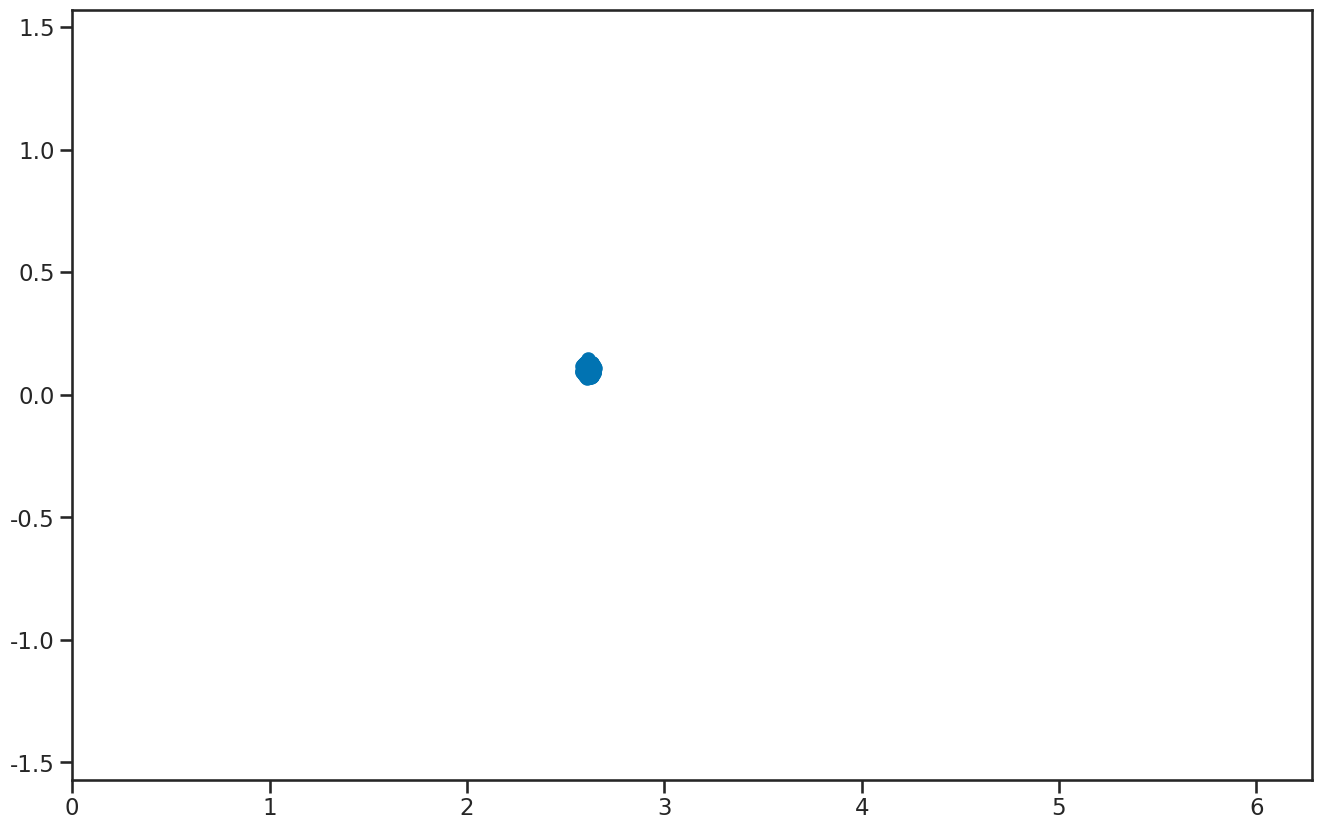

In [8]:
plt.scatter(samples[:,1],samples[:,2])
plt.xlim(0,2*np.pi)
plt.ylim(-np.pi/2,np.pi/2)
plt.show()

In [13]:
ras = np.concatenate(ras)
decs = np.concatenate(decs)
dLs = np.concatenate(dLs)


In [10]:
import h5py
with h5py.File('lognormal_pixelated_gws_pos_only.h5', 'w') as f:
    f.attrs['nsamp'] = 4096
    f.attrs['nobs'] = 1000
    f.create_dataset('dL', data=dLs, compression='gzip', shuffle=False)
    f.create_dataset('ra', data=ras, compression='gzip', shuffle=False)
    f.create_dataset('dec', data=decs, compression='gzip', shuffle=False)
